In [ ]:
pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.4 MB/s eta 0:00:00


✅ df shape: (54, 13)
✅ columnas: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'pH', ' CE (dS/m)', 'M.O %', 'N %', 'D.A', 'POROSIDAD', 'TEXTURA ', 'pH agua', 'Nitrogeno agua mg/L', 'CE agua (dS/m)']

✅ columnas limpias: ['pH', 'CE (dS/m)', 'M.O %', 'N %', 'D.A', 'POROSIDAD', 'TEXTURA', 'pH agua', 'Nitrogeno agua mg/L', 'CE agua (dS/m)']

📌 columnas elegidas:
MO_suelo  -> M.O %
DA_suelo  -> D.A
N_agua    -> Nitrogeno agua mg/L
CE_agua   -> CE agua (dS/m)

✅ Filas útiles (sin NaN): 54

✅ Resumen Impacto_fuzzy:
count    54.000000
mean     30.141219
std       2.564489
min      29.119271
25%      29.119271
50%      29.119271
75%      29.119271
max      38.923409
Name: Impacto_fuzzy, dtype: float64

✅ Conteo Riesgo_fuzzy:
Riesgo_fuzzy
Bajo    54
Name: count, dtype: int64


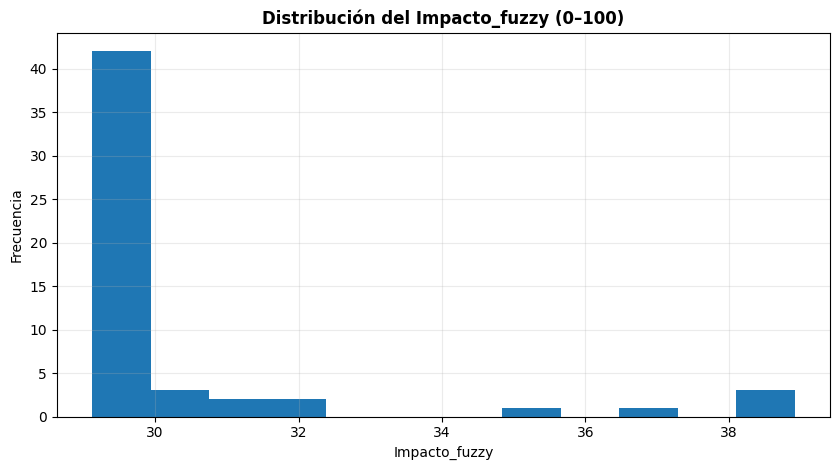

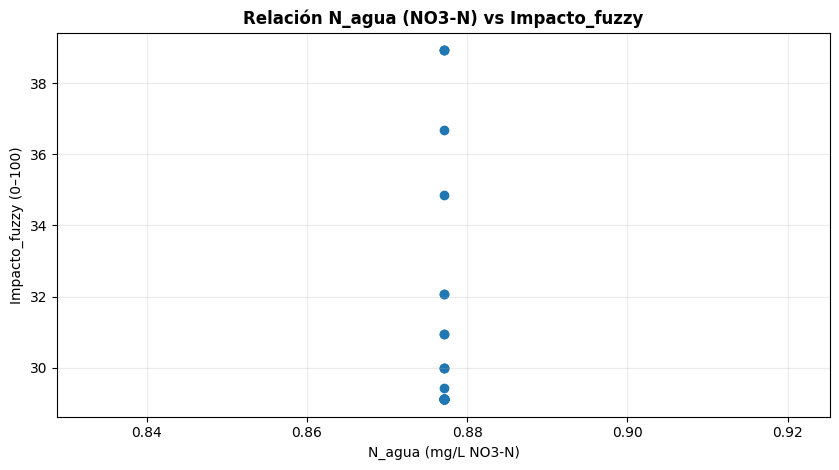

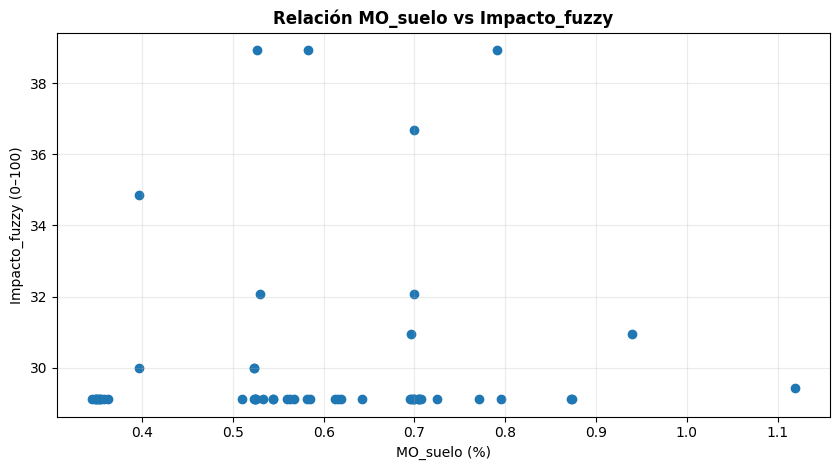

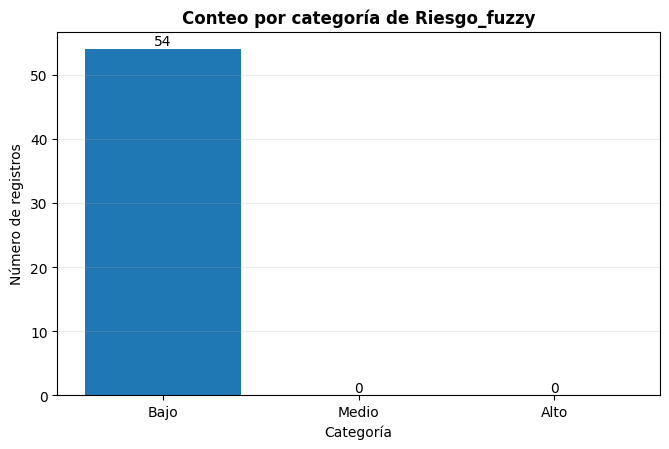


✅ Archivos guardados:
- res_hist_impacto.png
- res_scatter_N_vs_impacto.png
- res_scatter_MO_vs_impacto.png
- res_barras_riesgo.png
- top10_criticos.csv
- resultados_fuzzy_completos.csv


In [ ]:
# ====== 0) Instalar si hace falta ======
# !pip -q install scikit-fuzzy

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl


# ====== 1) Cargar CSV desde tu GitHub ======
url = "https://raw.githubusercontent.com/luicamongi/Impacto_ambiental/refs/heads/main/Data_suelo_USCO_agua_magdalena.csv?token=GHSAT0AAAAAADSELRPGQP5BT6DZMFJ3STV42KWOSOA"

df = pd.read_csv(url, encoding="utf-8-sig")
print("✅ df shape:", df.shape)
print("✅ columnas:", df.columns.tolist())
df.head()


# ====== 2) Limpieza rápida de nombres de columnas ======
df.columns = [c.strip() for c in df.columns]

# A veces GitHub/Excel meten columnas raras tipo "Unnamed: 0"
df = df.loc[:, ~df.columns.str.contains("^Unnamed", na=False)]

print("\n✅ columnas limpias:", df.columns.tolist())


# ====== 3) Selección/mapeo automático de columnas (según tu CSV) ======
# En tu archivo se ven estos nombres (o muy parecidos):
# "M.O %", "D.A", "Nitrogeno agua mg/L", "CE agua (dS/m) ...", etc. :contentReference[oaicite:1]{index=1}

def pick_col_contains(substrings):
    """Devuelve la primera columna cuyo nombre contenga todos los substrings (case-insensitive)."""
    for c in df.columns:
        name = c.lower()
        if all(s.lower() in name for s in substrings):
            return c
    return None

col_MO = pick_col_contains(["m.o"]) or pick_col_contains(["m.o", "%"]) or "M.O %"
col_DA = pick_col_contains(["d.a"]) or "D.A"
col_Nagua = pick_col_contains(["nitrogeno", "agua"]) or "Nitrogeno agua mg/L"
col_CEagua = pick_col_contains(["ce agua"]) or pick_col_contains(["ce", "agua"])

print("\n📌 columnas elegidas:")
print("MO_suelo  ->", col_MO)
print("DA_suelo  ->", col_DA)
print("N_agua    ->", col_Nagua)
print("CE_agua   ->", col_CEagua)

# Validación mínima
need = [col_MO, col_DA, col_Nagua, col_CEagua]
if any(c is None or c not in df.columns for c in need):
    raise ValueError("No encontré alguna columna clave. Pega df.columns.tolist() y te lo ajusto en 1 tiro.")


# ====== 4) Construir dataframe de trabajo + conversión de unidades ======
work = df.copy()

# Convertir a numérico
for c in [col_MO, col_DA, col_Nagua, col_CEagua]:
    work[c] = pd.to_numeric(work[c], errors="coerce")

# ⚠️ CE_agua en tu dataset está en dS/m → fuzzy usa µS/cm
# 1 dS/m = 1000 µS/cm
work["CE_agua_uScm"] = work[col_CEagua] * 1000.0

# Renombrar a nombres estándar del fuzzy
work["MO_suelo"] = work[col_MO]
work["DA_suelo"] = work[col_DA]
work["N_agua_NO3N"] = work[col_Nagua]
work["CE_agua"] = work["CE_agua_uScm"]

# Quitar filas sin datos
work = work.dropna(subset=["MO_suelo", "DA_suelo", "N_agua_NO3N", "CE_agua"]).reset_index(drop=True)
print("\n✅ Filas útiles (sin NaN):", work.shape[0])
work[["MO_suelo", "DA_suelo", "N_agua_NO3N", "CE_agua"]].head()


# ====== 5) Definir sistema difuso (igual al que ya hicimos) ======
N_min, N_max = 0, 15
MO_min, MO_max = 0, 6
DA_min, DA_max = 0.9, 1.9
CE_min, CE_max = 0, 2000
I_min, I_max = 0, 100

N  = ctrl.Antecedent(np.linspace(N_min,  N_max,  401), 'N_agua_NO3N')
MO = ctrl.Antecedent(np.linspace(MO_min, MO_max, 401), 'MO_suelo')
DA = ctrl.Antecedent(np.linspace(DA_min, DA_max, 401), 'DA_suelo')
CE = ctrl.Antecedent(np.linspace(CE_min, CE_max, 401), 'CE_agua')
Impacto = ctrl.Consequent(np.linspace(I_min, I_max, 401), 'Impacto')

MO['baja']  = fuzz.trapmf(MO.universe, [0, 0, 1.10, 1.60])
MO['media'] = fuzz.trimf(MO.universe, [1.50, 2.25, 3.00])
MO['alta']  = fuzz.trapmf(MO.universe, [2.90, 3.40, 6.00, 6.00])

N['bajo']  = fuzz.trapmf(N.universe, [0, 0, 7.0, 10.0])
N['medio'] = fuzz.trimf(N.universe, [8.0, 10.5, 13.0])
N['alto']  = fuzz.trapmf(N.universe, [11.0, 13.0, 15.0, 15.0])

# Rangos tuyos de DA en suelos arroceros
DA['baja']  = fuzz.trapmf(DA.universe, [DA_min, DA_min, 1.10, 1.25])
DA['media'] = fuzz.trimf(DA.universe, [1.20, 1.35, 1.50])
DA['alta']  = fuzz.trapmf(DA.universe, [1.55, 1.65, DA_max, DA_max])

CE['baja']  = fuzz.trapmf(CE.universe, [0, 0, 600, 850])
CE['media'] = fuzz.trimf(CE.universe, [800, 1150, 1500])
CE['alta']  = fuzz.trapmf(CE.universe, [1400, 1600, 2000, 2000])

Impacto['bajo']  = fuzz.trapmf(Impacto.universe, [0, 0, 25, 40])
Impacto['medio'] = fuzz.trimf(Impacto.universe, [30, 50, 70])
Impacto['alto']  = fuzz.trapmf(Impacto.universe, [60, 75, 100, 100])

rules = [
    ctrl.Rule(N['alto'] & MO['baja'] & DA['baja'], Impacto['alto']),
    ctrl.Rule(N['alto'] & MO['baja'] & DA['media'], Impacto['alto']),
    ctrl.Rule(N['alto'] & MO['baja'] & DA['alta'], Impacto['alto']),
    ctrl.Rule(N['alto'] & MO['media'] & DA['baja'], Impacto['alto']),
    ctrl.Rule(N['alto'] & MO['media'] & DA['media'], Impacto['alto']),
    ctrl.Rule(N['alto'] & MO['media'] & DA['alta'], Impacto['medio']),
    ctrl.Rule(N['alto'] & MO['alta'] & DA['baja'], Impacto['medio']),
    ctrl.Rule(N['alto'] & MO['alta'] & DA['media'], Impacto['medio']),
    ctrl.Rule(N['alto'] & MO['alta'] & DA['alta'], Impacto['medio']),

    ctrl.Rule(N['medio'] & MO['baja'] & DA['baja'], Impacto['alto']),
    ctrl.Rule(N['medio'] & MO['baja'] & DA['media'], Impacto['medio']),
    ctrl.Rule(N['medio'] & MO['baja'] & DA['alta'], Impacto['medio']),
    ctrl.Rule(N['medio'] & MO['media'] & DA['baja'], Impacto['medio']),
    ctrl.Rule(N['medio'] & MO['media'] & DA['media'], Impacto['medio']),
    ctrl.Rule(N['medio'] & MO['media'] & DA['alta'], Impacto['bajo']),
    ctrl.Rule(N['medio'] & MO['alta'] & DA['baja'], Impacto['medio']),
    ctrl.Rule(N['medio'] & MO['alta'] & DA['media'], Impacto['bajo']),
    ctrl.Rule(N['medio'] & MO['alta'] & DA['alta'], Impacto['bajo']),

    ctrl.Rule(N['bajo'] & MO['baja'] & DA['baja'], Impacto['medio']),
    ctrl.Rule(N['bajo'] & MO['baja'] & DA['media'], Impacto['medio']),
    ctrl.Rule(N['bajo'] & MO['baja'] & DA['alta'], Impacto['bajo']),
    ctrl.Rule(N['bajo'] & MO['media'] & DA['baja'], Impacto['bajo']),
    ctrl.Rule(N['bajo'] & MO['media'] & DA['media'], Impacto['bajo']),
    ctrl.Rule(N['bajo'] & MO['media'] & DA['alta'], Impacto['bajo']),
    ctrl.Rule(N['bajo'] & MO['alta'] & DA['alta'], Impacto['bajo']),

    ctrl.Rule(CE['alta'] & N['alto'], Impacto['alto']),
    ctrl.Rule(CE['alta'] & N['medio'] & MO['baja'], Impacto['alto']),
    ctrl.Rule(CE['alta'] & N['medio'] & MO['media'], Impacto['medio']),
    ctrl.Rule(CE['alta'] & N['bajo'] & MO['baja'], Impacto['medio']),

    ctrl.Rule(N['bajo'] | N['medio'] | N['alto'], Impacto['medio']),
]

system = ctrl.ControlSystem(rules)

def fuzzy_impact(n, mo, da, ce):
    sim = ctrl.ControlSystemSimulation(system)
    sim.input["N_agua_NO3N"] = float(n)
    sim.input["MO_suelo"] = float(mo)
    sim.input["DA_suelo"] = float(da)
    sim.input["CE_agua"] = float(ce)
    sim.compute()
    return float(sim.output["Impacto"])


# ====== 6) Calcular impacto por fila ======
work["Impacto_fuzzy"] = work.apply(
    lambda r: fuzzy_impact(r["N_agua_NO3N"], r["MO_suelo"], r["DA_suelo"], r["CE_agua"]),
    axis=1
)

# Clasificación (ajustable)
def clasificar(x):
    if x < 40:
        return "Bajo"
    elif x < 70:
        return "Medio"
    return "Alto"

work["Riesgo_fuzzy"] = work["Impacto_fuzzy"].apply(clasificar)

print("\n✅ Resumen Impacto_fuzzy:")
print(work["Impacto_fuzzy"].describe())
print("\n✅ Conteo Riesgo_fuzzy:")
print(work["Riesgo_fuzzy"].value_counts())


# ====== 7) Gráficas de resultados (chimbas) + guardado ======
# A) Histograma
plt.figure(figsize=(8.5, 4.8))
plt.hist(work["Impacto_fuzzy"], bins=12)
plt.title("Distribución del Impacto_fuzzy (0–100)", weight="bold")
plt.xlabel("Impacto_fuzzy")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()
plt.savefig("res_hist_impacto.png", dpi=300, bbox_inches="tight")
plt.close()

# B) Scatter: N_agua vs Impacto
plt.figure(figsize=(8.5, 4.8))
plt.scatter(work["N_agua_NO3N"], work["Impacto_fuzzy"])
plt.title("Relación N_agua (NO3-N) vs Impacto_fuzzy", weight="bold")
plt.xlabel("N_agua (mg/L NO3-N)")
plt.ylabel("Impacto_fuzzy (0–100)")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()
plt.savefig("res_scatter_N_vs_impacto.png", dpi=300, bbox_inches="tight")
plt.close()

# C) Scatter: MO vs Impacto
plt.figure(figsize=(8.5, 4.8))
plt.scatter(work["MO_suelo"], work["Impacto_fuzzy"])
plt.title("Relación MO_suelo vs Impacto_fuzzy", weight="bold")
plt.xlabel("MO_suelo (%)")
plt.ylabel("Impacto_fuzzy (0–100)")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()
plt.savefig("res_scatter_MO_vs_impacto.png", dpi=300, bbox_inches="tight")
plt.close()

# D) Barras por categoría
counts = work["Riesgo_fuzzy"].value_counts().reindex(["Bajo","Medio","Alto"], fill_value=0)
plt.figure(figsize=(6.8, 4.6))
bars = plt.bar(counts.index, counts.values)
plt.title("Conteo por categoría de Riesgo_fuzzy", weight="bold")
plt.xlabel("Categoría")
plt.ylabel("Número de registros")
plt.grid(axis="y", alpha=0.25)
for b in bars:
    y = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, y + 0.1, f"{int(y)}", ha="center", va="bottom")
plt.tight_layout()
plt.show()
plt.savefig("res_barras_riesgo.png", dpi=300, bbox_inches="tight")
plt.close()

# Top 10 críticos
top10 = work.sort_values("Impacto_fuzzy", ascending=False).head(10)
top10.to_csv("top10_criticos.csv", index=False)

# Export general
work.to_csv("resultados_fuzzy_completos.csv", index=False)

print("\n✅ Archivos guardados:")
print("- res_hist_impacto.png")
print("- res_scatter_N_vs_impacto.png")
print("- res_scatter_MO_vs_impacto.png")
print("- res_barras_riesgo.png")
print("- top10_criticos.csv")
print("- resultados_fuzzy_completos.csv")
